In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import clear_output
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import permutation_test_score
from mlxtend.evaluate import permutation_test


In [2]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [3]:
MAX_NUMBER_OF_GENES = 70
NUMBER_OF_CLUSTERS = 2
QUINTILE_VAL = 0.01
# path = "/cs/labs/michall/roeizucker/virt_env_install_test/ukbb_imputation_gene_effect_scores/"
EFFECT_SCORE_PATH = "/cs/labs/michall/roeizucker/virt_env_install_test/ukbb_imputation_gene_effect_scores/"


In [4]:
ukbb_dataset = pd.read_csv("/cs/labs/michall/roeizucker/hypertension_study/clustering_data/ukbb_dataset.csv")
I10_df = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/I10_1.csv")
I10_M_df = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/I10_M.csv")
I10_F_df = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/I10_F.csv")

In [5]:
E03_df = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/E03_1.csv")
E03_M_df = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/E03_M.csv")
E03_F_df = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/E03_F.csv")

In [6]:
ukbb_dataset["E03"].value_counts()

0.0    261321
1.0     13696
Name: E03, dtype: int64

In [7]:
gene_transaltion = I10_df[["gene_index","uniprot_id"]]
GENE_DICT = {}
for i in gene_transaltion.T.iteritems():
    GENE_DICT[i[1]["gene_index"]] = i[1]["uniprot_id"]


In [8]:

# change to get gene_dcit as parameter
def create_effect_score_df(path,used_genes,used_ids,gene_dict):
    directory = os.fsencode(path)
    counter = 0
    dfs = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"):
            counter+=1
            if counter%100 == 0:
                clear_output(wait=True)
                print(counter)
            gene_index = filename.replace(".csv","")
            if gene_dict[int(gene_index)] not in used_genes:
                continue
            df = pd.read_csv(path + filename)
            df = df[df["sample_id"].isin(used_ids)]
            df.set_index("sample_id",inplace=True)
            dfs.append((gene_dict[int(gene_index)],df))
    
    values_df = dfs[0][1][[]]
    for df in dfs:
        values_df[df[0]] = df[1]["dominant"]
    return values_df


In [9]:
def set_quintile(df,ukbb_dataset,col):
    df[col] = ukbb_dataset[col]
    quintiles = df[col].quantile(np.arange(0,1,QUINTILE_VAL))
    for i, quint in enumerate(quintiles):
#         df[df[col] > quint][col] = (len(quintiles) - i)*QUINTILE_VAL
        df.loc[df[col] > quint,col] = (i + 1)*QUINTILE_VAL
    return df

In [10]:
ALL_PHENS = ["BMI","White blood cell count","Lymphocyte counts","Height"]
ADDED_PHENOTYPES = [["BMI"],["BMI","White blood cell count"],["BMI","White blood cell count","Lymphocyte counts"],
                   ["BMI","White blood cell count","Lymphocyte counts","Height"]]

def print_statistics(curr_ukbb_dataset):
        fp = len(curr_ukbb_dataset.query("(group_clust == 0) and (I10 == 0.0) "))
        tp = len(curr_ukbb_dataset.query("(group_clust == 0) and (I10 == 1.0) "))
        tn = len(curr_ukbb_dataset.query("(group_clust == 1) and (I10 == 0.0) "))
        fn = len(curr_ukbb_dataset.query("(group_clust == 1) and (I10 == 1.0) "))
        count = len(curr_ukbb_dataset)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = tp / (tp + 1/2 * (fp + fn))
        print("FP", round(fp/count,4))
        print("TP",round(tp/count,4))
        print("TN",round( tn/count,4))
        print("FN",round( fn/count,4))
        print("precision",round( precision,4))
        print("recall", round(recall,4))
        print("f1 score", round(f1,4))

def whole_procedure(phen_to_compare,ukbb_dataset,I10_df):
    used_ids = list(ukbb_dataset.query(f"(I10 == 1.0 or {phen_to_compare} == 1.0 ) and {phen_to_compare} != I10")["eid"])
    phen_to_compare_df = pd.read_csv(f"/cs/labs/michall/roeizucker/10krun/results/{phen_to_compare}_1.csv")
    genes_list = (list(I10_df.query("fdr_significance")["uniprot_id"]))
    genes_list.extend(list(phen_to_compare_df.query("fdr_significance")["uniprot_id"]))
    used_genes = set(genes_list)
    # curr_df.columns
    curr_ukbb_dataset = ukbb_dataset.copy()
    curr_ukbb_dataset = curr_ukbb_dataset.rename(columns={'eid': 'sample_id'})
    curr_ukbb_dataset = curr_ukbb_dataset[curr_ukbb_dataset["sample_id"].isin(used_ids)]

    curr_ukbb_dataset.set_index("sample_id",inplace=True)
    df = create_effect_score_df(EFFECT_SCORE_PATH,used_genes,used_ids,GENE_DICT) 
    print(phen_to_compare)
    
    curr_df = df.copy()
    #         curr_df = create_effect_score_df(EFFECT_SCORE_PATH,used_genes,used_ids,GENE_DICT) 

    #         makes sure to remove participants that don't have a mesurment.
    for phen in ALL_PHENS:
        curr_df[phen] = curr_ukbb_dataset[phen]
    curr_df = curr_df.dropna()
    curr_df = curr_df.drop(ALL_PHENS, axis=1)
    
    for phens in ADDED_PHENOTYPES:
    #         add new phenotypes to data
        for phen in phens:
#             print(phen)
            curr_df = set_quintile(curr_df,curr_ukbb_dataset,phen)
#             print(curr_df.columns)
        curr_df = curr_df.drop(phens, axis=1)
        curr_df = curr_df.dropna()
        cluster = AgglomerativeClustering(n_clusters=NUMBER_OF_CLUSTERS, affinity='euclidean', linkage='ward')
        y = cluster.fit_predict(curr_df)
        # print(curr_df[:,0],curr_df[:,1])
        # plt.scatter(curr_df["Q8N4B1"],curr_df["Q9UQQ2"], c=cluster.labels_, cmap='rainbow')
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(curr_df[list(curr_df.columns)[:-1]].values)
        curr_df['pca-one'] = pca_result[:,0]
        curr_df['pca-two'] = pca_result[:,1] 
        curr_df["labels"] = cluster.labels_
        curr_df["sex"] = curr_ukbb_dataset["sex"]
        #     curr_df["y"] = y
        curr_df["lable"] =  cluster.labels_
        curr_ukbb_dataset["group_clust"] = curr_df["lable"] 
        res_dict = dict(curr_df.query('lable==1').mean() - curr_df.query('lable==0').mean())
        #     del res_dict['y']
        del res_dict['pca-two']
        del res_dict['pca-one']
        del res_dict['sex']
        del res_dict["lable"]
        del res_dict["labels"]
        print(phens)
        print_statistics(curr_ukbb_dataset)
whole_procedure("E11",ukbb_dataset,I10_df) 

17900
E11


/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['BMI']
FP 0.0522
TP 0.6836
TN 0.0178
FN 0.2098
precision 0.9291
recall 0.7651
f1 score 0.8392
['BMI', 'White blood cell count']
FP 0.0522
TP 0.6836
TN 0.0178
FN 0.2098
precision 0.9291
recall 0.7652
f1 score 0.8392
['BMI', 'White blood cell count', 'Lymphocyte counts']
FP 0.0522
TP 0.6837
TN 0.0178
FN 0.2097
precision 0.929
recall 0.7653
f1 score 0.8392
['BMI', 'White blood cell count', 'Lymphocyte counts', 'Height']
FP 0.0522
TP 0.6839
TN 0.0178
FN 0.2095
precision 0.929
recall 0.7655
f1 score 0.8394


In [11]:
ALL_PHENS = ["BMI","White blood cell count","Lymphocyte counts","Height"]
ADDED_PHENOTYPES = [["BMI"],["BMI","White blood cell count"],["BMI","White blood cell count","Lymphocyte counts"],
                   ["BMI","White blood cell count","Lymphocyte counts","Height"]]
phen_to_compare = "E78"
phens = ALL_PHENS
used_ids = list(ukbb_dataset.query(f"(I10 == 1.0 or {phen_to_compare} == 1.0 ) and {phen_to_compare} != I10")["eid"])
phen_to_compare_df = pd.read_csv(f"/cs/labs/michall/roeizucker/10krun/results/{phen_to_compare}_1.csv")
genes_list = (list(I10_df.query("fdr_significance")["uniprot_id"]))
genes_list.extend(list(phen_to_compare_df.query("fdr_significance")["uniprot_id"]))
used_genes = set(genes_list)
# curr_df.columns
curr_ukbb_dataset = ukbb_dataset.copy()
curr_ukbb_dataset = curr_ukbb_dataset.rename(columns={'eid': 'sample_id'})
curr_ukbb_dataset = curr_ukbb_dataset[curr_ukbb_dataset["sample_id"].isin(used_ids)]

curr_ukbb_dataset.set_index("sample_id",inplace=True)
df = create_effect_score_df(EFFECT_SCORE_PATH,used_genes,used_ids,GENE_DICT) 


17900


/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
curr_df = df.copy()
#         curr_df = create_effect_score_df(EFFECT_SCORE_PATH,used_genes,used_ids,GENE_DICT) 

#         makes sure to remove participants that don't have a mesurment.
for phen in ALL_PHENS:
    curr_df[phen] = curr_ukbb_dataset[phen]
curr_df = curr_df.dropna()
curr_df = curr_df.drop(ALL_PHENS, axis=1)

#         add new phenotypes to data
for phen in phens:
    curr_df = set_quintile(curr_df,curr_ukbb_dataset,phen)
curr_df = curr_df.dropna()
cluster = AgglomerativeClustering(n_clusters=NUMBER_OF_CLUSTERS, affinity='euclidean', linkage='ward')
y = cluster.fit_predict(curr_df)
# print(curr_df[:,0],curr_df[:,1])
# plt.scatter(curr_df["Q8N4B1"],curr_df["Q9UQQ2"], c=cluster.labels_, cmap='rainbow')
pca = PCA(n_components=2)
pca_result = pca.fit_transform(curr_df[list(curr_df.columns)[:-1]].values)
curr_df['pca-one'] = pca_result[:,0]
curr_df['pca-two'] = pca_result[:,1] 
curr_df["labels"] = cluster.labels_
curr_df["sex"] = curr_ukbb_dataset["sex"]
#     curr_df["y"] = y
curr_df["lable"] =  cluster.labels_
curr_ukbb_dataset["group_clust"] = curr_df["lable"] 
res_dict = dict(curr_df.query('lable==1').mean() - curr_df.query('lable==0').mean())
#     del res_dict['y']
del res_dict['pca-two']
del res_dict['pca-one']
del res_dict['sex']
del res_dict["lable"]
del res_dict["labels"]
# print(phens)
print(sorted(list(res_dict.items()),key=lambda x:np.abs(x[1])))
fp = len(curr_ukbb_dataset.query("(group_clust == 0) and (I10 == 0.0) "))
tp = len(curr_ukbb_dataset.query("(group_clust == 0) and (I10 == 1.0) "))
tn = len(curr_ukbb_dataset.query("(group_clust == 1) and (I10 == 0.0) "))
fn = len(curr_ukbb_dataset.query("(group_clust == 1) and (I10 == 1.0) "))
count = len(curr_ukbb_dataset)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = tp / (tp + 1/2 * (fp + fn))
print("FP", round(fp/count,4))
print("TP",round(tp/count,4))
print("TN",round( tn/count,4))
print("FN",round( fn/count,4))
print("precision",round( precision,4))
print("recall", round(recall,4))
print("f1 score", round(f1,4))
# list(curr_df["BMI"])

[('White blood cell count', 1.7369252948602754e-07), ('Lymphocyte counts', 5.210775884546132e-07), ('BMI', -0.00022116790856825316), ('O75955', 0.0010340880810448816), ('Q9HB58', -0.005614965952981471), ('P08235', 0.005975686675173897), ('P36873', 0.00735999237159779), ('Q86X59', 0.009550239515761005), ('Q9H221', -0.01166230081998676), ('P51788', 0.011692719972018595), ('Q9NQ94', 0.015322164074409894), ('Q96R08', 0.022090227867781247), ('A2RUH7', 0.02262707050965218), ('Q8NBP7', -0.02742851870397578), ('Q12769', -0.028680750624598295), ('Q96D42', -0.03171568480039718), ('P06727', 0.032403029413614004), ('Q9UH65', -0.03379451617633278), ('Q9NRE1', 0.03691952736430271), ('Q14684', -0.0390899071358104), ('Q0P670', 0.04109534769490897), ('O14594', 0.04189077250864126), ('P29474', -0.04230868213884964), ('Q96FS4', 0.04265002708030663), ('P15151', 0.04568476426409951), ('P01138', -0.04728312783509614), ('O14905', -0.04744171921510082), ('Q14183', -0.0496828413218835), ('P46379', -0.049782589

In [13]:
count

59715

In [14]:
gene_transaltion = I10_df[["gene_index","uniprot_id"]]
GENE_DICT = {}
for i in gene_transaltion.T.iteritems():
    GENE_DICT[i[1]["gene_index"]] = i[1]["uniprot_id"]


In [15]:
# list(ukbb_dataset.columns)

In [16]:
# for num in range(len(ukbb_dataset.columns)):
#     col = ukbb_dataset.columns[num]
# #     print(col)
#     length = ukbb_dataset[col].sum()
#     if length > 30000:
#         print(col, length)

In [17]:
# used_ids = list(ukbb_dataset.query("I10 == 1.0")["eid"])
# used_ids = list(ukbb_dataset.query("(I10 == 1.0 or H269 == 1.0) and (I10 != H269)")["eid"])
# used_ids = list(ukbb_dataset.query("(I10 == 1.0 or H269 == 1.0 )")["eid"])
# used_ids = list(ukbb_dataset.query("(I10 == 1.0 or E78 == 1.0 )")["eid"])
used_ids = list(ukbb_dataset.query("(I10 == 1.0 or E78 == 1.0 ) and E78 != I10")["eid"])


genes_list = list(I10_df.query("fdr_significance")["uniprot_id"])
length = min(len(genes_list),MAX_NUMBER_OF_GENES)
used_genes = set(list(I10_df.query("fdr_significance")["uniprot_id"])[0:length])


In [18]:
ukbb_dataset.query("(E78 == 1.0)")

,sample_index,eid,Height,BMI,Waist circumference,Hip circumference,Diastolic blood pressure,Systolic blood pressure,Menarche (age at onset),Menopause (age at onset),...,batch_UKBiLEVEAX_b1,batch_UKBiLEVEAX_b10,batch_UKBiLEVEAX_b11,batch_UKBiLEVEAX_b3,batch_UKBiLEVEAX_b4,batch_UKBiLEVEAX_b5,batch_UKBiLEVEAX_b6,batch_UKBiLEVEAX_b7,batch_UKBiLEVEAX_b8,batch_UKBiLEVEAX_b9
1,1,5764375,163.0,28.9811,102.0,105.0,94.0,131.0,12.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5503073,184.0,35.9168,115.0,121.0,84.0,127.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2563626,167.0,29.4381,94.0,103.0,80.0,134.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,30,3319543,178.0,25.6596,94.0,99.0,74.0,115.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,38,2958603,167.0,29.7608,109.0,102.0,76.0,162.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333600,502478,1605571,170.0,36.1592,113.0,118.0,96.0,144.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333615,502498,3454875,174.0,27.6126,102.0,98.0,91.0,157.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333616,502499,5399177,150.0,25.8667,86.0,95.0,80.0,152.0,11.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333627,502513,2243883,169.0,30.5311,106.0,102.0,75.0,133.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# ukbb_dataset

In [20]:

# path = "/cs/labs/michall/roeizucker/virt_env_install_test/ukbb_imputation_gene_effect_scores/"
# directory = os.fsencode(path)
# counter = 0
# dfs = []
# for file in os.listdir(directory):
#     filename = os.fsdecode(file)
#     if filename.endswith(".csv"):
#         counter+=1
#         if counter%1000 == 0:
#             clear_output(wait=True)
#             print(counter)
#         gene_index = filename.replace(".csv","")
#         if gene_dict[int(gene_index)] not in used_genes:
#             continue
#         df = pd.read_csv(path + filename)
#         df = df[df["sample_id"].isin(used_ids)]
#         df.set_index("sample_id",inplace=True)
#         dfs.append((gene_dict[int(gene_index)],df))
    


In [21]:
# values_df = dfs[0][1][[]]
# for df in dfs:
#     values_df[df[0]] = df[1]["dominant"]



In [22]:
values_df = create_effect_score_df(EFFECT_SCORE_PATH,used_genes,used_ids,GENE_DICT)

17900


/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
df = values_df
  
kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS).fit(df)
y = kmeans.fit_predict(df)
df['y'] = y
# centroids = kmeans.cluster_centers_
# print(centroids)

# plt.scatter(df['x'], df['y'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
# # plt.show()
# plt.show()


In [24]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[list(df.columns)[:-1]].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]


In [25]:
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# print(pca.components_)

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

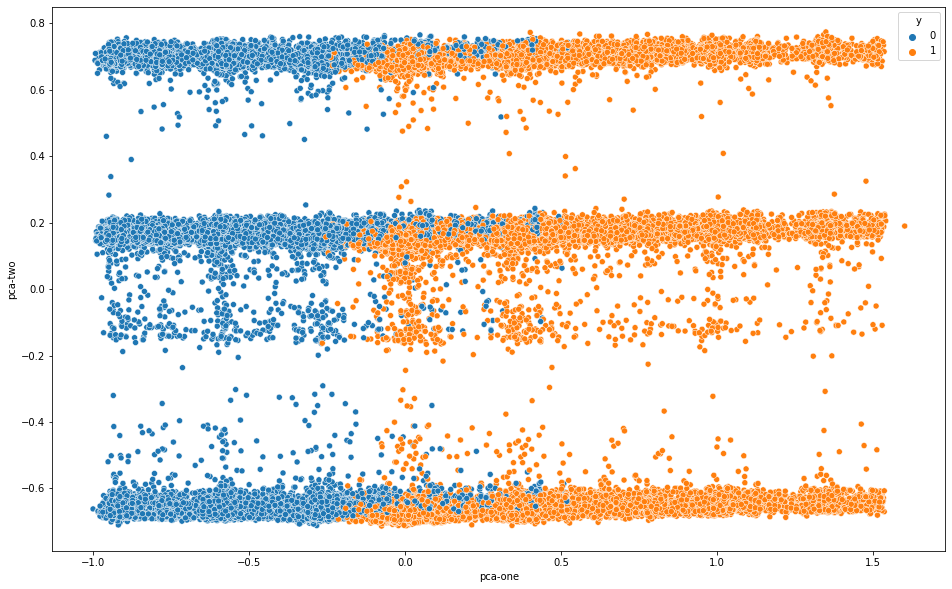

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
#     alpha=0.3
)


In [27]:
ukbdataset_work = ukbb_dataset.copy()
ukbdataset_work = ukbdataset_work.rename(columns={'eid': 'sample_id'})
ukbdataset_work = ukbdataset_work[ukbdataset_work["sample_id"].isin(used_ids)]
# print(ukbdataset_work)
ukbdataset_work.set_index("sample_id",inplace=True)

In [28]:
df["sex"] = ukbdataset_work["sex"]

In [29]:
ukbdataset_work["group"] = df["y"]
ukbdataset_work.query('group == 0 and I10 == 1')

,sample_index,Height,BMI,Waist circumference,Hip circumference,Diastolic blood pressure,Systolic blood pressure,Menarche (age at onset),Menopause (age at onset),Intraocular pressure,...,batch_UKBiLEVEAX_b10,batch_UKBiLEVEAX_b11,batch_UKBiLEVEAX_b3,batch_UKBiLEVEAX_b4,batch_UKBiLEVEAX_b5,batch_UKBiLEVEAX_b6,batch_UKBiLEVEAX_b7,batch_UKBiLEVEAX_b8,batch_UKBiLEVEAX_b9,group
sample_id,,,,,,,,,,,,,,,,,,,,,
3051770,18,173.0,30.3385,106.0,108.0,90.0,132.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1905371,70,162.0,34.6746,104.0,125.0,85.0,133.0,14.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456093,82,149.0,35.8092,101.0,122.0,83.0,131.0,15.0,40.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1568575,85,167.0,31.4461,95.0,117.0,70.0,128.0,14.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2684885,109,180.0,29.0123,105.0,101.0,86.0,124.0,NaN,NaN,17.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144545,502343,161.0,30.2072,100.0,106.0,95.0,161.0,12.0,37.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2374048,502367,157.0,24.8286,81.0,92.0,80.0,123.0,13.0,50.0,12.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2184104,502397,181.0,24.3582,108.0,102.0,82.0,144.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
res_dict = dict(df.query('y==1').mean() - df.query('y==0').mean())
del res_dict['y']
del res_dict['pca-two']
del res_dict['pca-one']
del res_dict['sex']
print(sorted(list(res_dict.items()),key=lambda x:np.abs(x[1])))


[('P33241', 8.194899829838675e-07), ('Q99466', 2.74750508165722e-05), ('Q9HC10', -3.7023802073821166e-05), ('Q7Z2Z1', -6.168940483730623e-05), ('P46379', -7.952890760765108e-05), ('Q9P212', -0.0001063264046294865), ('Q14684', -0.00015241397230847387), ('Q0P670', 0.00033158648499753696), ('Q9P275', -0.00034745940270974884), ('O15118', 0.0004005354585444043), ('P59942', 0.00043163919967847963), ('Q9Y6M7', 0.00045521184893881905), ('P09172', 0.0004568175410821773), ('Q16891', -0.0004918575511735357), ('P11230', -0.000520008874685951), ('Q5U651', 0.0006222768973699888), ('P01019', -0.0006561046246064128), ('Q86X59', 0.0006902362490541769), ('P53985', 0.0007052012542642094), ('Q14183', 0.000707097152111813), ('Q9UH65', 0.0007189608261248814), ('P09681', -0.0007450014943664041), ('P08235', 0.0007918782861764395), ('Q8IYN0', -0.0008979483185970194), ('P01138', -0.0008991920436924872), ('Q6ZR52', 0.0009171736432982414), ('Q8N5B7', 0.0009511197003273519), ('P22105', 0.0010172526145966199), ('P2

In [31]:
# ('Q8N5B7', 0.0018626626773421973), ('Q10981', 0.0021598000102933113), ('Q30201', 0.9060853687219025)
# ('Q10981', -0.005507519507237879), ('Q9UQQ2', -0.309621587246392), ('Q8N4B1', -0.9868582709153416)
# ('Q10981', -0.005507519507237879), ('Q9UQQ2', -0.309621587246392), ('Q8N4B1', -0.9868582709153416)
# ('Q8NGF9', -0.2897975737796733), ('Q8NGL7', 0.4604666006570139), ('Q8NGF8', 0.7960412813616948)

In [32]:
# df["Q8N4B1"].hist(bins=20)

In [33]:
list(ukbb_dataset.columns)

['sample_index',
 'eid',
 'Height',
 'BMI',
 'Waist circumference',
 'Hip circumference',
 'Diastolic blood pressure',
 'Systolic blood pressure',
 'Menarche (age at onset)',
 'Menopause (age at onset)',
 'Intraocular pressure',
 'White blood cell count',
 'Lymphocyte counts',
 'C44',
 'C50',
 'D12',
 'D64',
 'D649',
 'E03',
 'E039',
 'E11',
 'E119',
 'E66',
 'E669',
 'E78',
 'E780',
 'F17',
 'F171',
 'F32',
 'F329',
 'H26',
 'H269',
 'I10',
 'I20',
 'I209',
 'I25',
 'I251',
 'I259',
 'I48',
 'I84',
 'I849',
 'J18',
 'J45',
 'J459',
 'K21',
 'K219',
 'K29',
 'K297',
 'K30',
 'K40',
 'K409',
 'K44',
 'K449',
 'K52',
 'K529',
 'K57',
 'K573',
 'K59',
 'K590',
 'K62',
 'K625',
 'K63',
 'K635',
 'K80',
 'M13',
 'M139',
 'M16',
 'M17',
 'M179',
 'M19',
 'M199',
 'M23',
 'M25',
 'M54',
 'M79',
 'N39',
 'N390',
 'N40',
 'N81',
 'N92',
 'R07',
 'R074',
 'R10',
 'R104',
 'R11',
 'R19',
 'R194',
 'R31',
 'R69',
 'T81',
 'Y83',
 'Z51',
 'Z53',
 'Z538',
 'Z82',
 'Z824',
 'Z85',
 'Z86',
 'Z864',
 '

# Hierarchical Clustering

## create_dataset

In [34]:
if "BMIquint" in res_dict:
    del res_dict['BMIquint']
if "White blood cell countquint" in res_dict:
    del res_dict['White blood cell countquint']

if "Lymphocyte countsquint" in res_dict:
    del res_dict['Lymphocyte countsquint']

if "Heightquint" in res_dict:
    del res_dict['Heightquint']
curr_df = df[res_dict.keys()]
# curr_df.columns
curr_ukbb_dataset = ukbb_dataset.copy()
curr_ukbb_dataset.set_index("eid",inplace=True)
curr_df["BMI"] = curr_ukbb_dataset["BMI"]
curr_df["BMI"] = curr_df["BMI"] /curr_df["BMI"].abs().max()

curr_df["White blood cell count"] = curr_ukbb_dataset["White blood cell count"]
curr_df["White blood cell count"] = curr_df["White blood cell count"] /curr_df["White blood cell count"].abs().max()

curr_df["Lymphocyte counts"] = curr_ukbb_dataset["Lymphocyte counts"]
curr_df["Lymphocyte counts"] = curr_df["Lymphocyte counts"] /curr_df["Lymphocyte counts"].abs().max()

curr_df["Height"] = curr_ukbb_dataset["Height"]
curr_df["Height"] = curr_df["Height"] /curr_df["Height"].abs().max()

# curr_df = set_quintile(curr_df,curr_ukbb_dataset,"BMI",res_dict)
# curr_df = set_quintile(curr_df,curr_ukbb_dataset,"White blood cell count",res_dict)
# curr_df = set_quintile(curr_df,curr_ukbb_dataset,"Lymphocyte counts",res_dict)
# curr_df = set_quintile(curr_df,curr_ukbb_dataset,"Height",res_dict)

# print(curr_ukbb_dataset["Lymphocyte counts"])
curr_df = curr_df.dropna()
curr_df
# list(curr_df["BMI"])

/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,Q8TEA7,O14905,Q8N3X1,O15118,Q8NGL7,P33241,P51788,Q8NGF9,Q9UI42,Q8TDW4,...,P22105,P46379,Q8N5B7,Q8IYN0,Q8NE65,Q8NGF8,BMI,White blood cell count,Lymphocyte counts,Height
sample_id,,,,,,,,,,,,,,,,,,,,,
3769417,0.808215,0.273226,0.033046,1.000000,0.927874,0.907589,0.874564,0.0,1.000000,1.000000,...,0.658968,0.804223,0.119017,0.427233,0.470558,0.996505,0.517517,0.103713,0.040643,0.811275
5530217,0.000000,0.273226,0.022500,0.300853,0.000000,0.802807,1.000000,1.0,0.002979,1.000000,...,0.853195,0.999668,0.119017,0.427233,1.000000,0.004524,0.311402,0.103218,0.023099,0.872549
2457659,0.000000,0.273226,0.022500,0.300853,0.894118,1.000000,0.844800,1.0,0.002979,1.000000,...,0.677483,0.996164,0.119017,0.423186,0.475820,0.990283,0.474242,0.066213,0.025585,0.823529
3582530,0.803253,0.273226,0.021865,0.361834,0.000000,1.000000,0.874564,1.0,0.002979,1.000000,...,0.731348,0.962876,1.000000,1.000000,0.475820,0.006832,0.410669,0.056436,0.016374,0.872549
3922623,0.825036,0.273145,0.022500,0.300853,0.000000,0.908864,1.000000,1.0,0.002979,1.000000,...,0.677471,0.804223,0.119017,1.000000,0.475820,0.006832,0.331879,0.067946,0.031725,0.789216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361430,0.000000,0.273226,0.022500,0.300853,0.225679,0.908864,0.874564,1.0,0.002979,0.400732,...,0.690844,0.804174,0.117681,0.427233,0.475820,0.006443,0.470638,0.118812,0.019006,0.877451
1282177,0.676933,0.273226,1.000000,0.300084,0.711503,1.000000,1.000000,1.0,1.000000,0.400732,...,0.723329,0.802734,0.119017,0.427233,0.475820,0.996606,0.453664,0.116337,0.059942,0.808824
1019062,0.487625,0.273226,0.855030,0.300997,0.994089,1.000000,0.874564,0.0,0.983143,1.000000,...,0.651535,0.803952,0.119017,0.340764,0.475820,0.996505,0.365980,0.081683,0.020468,0.955882


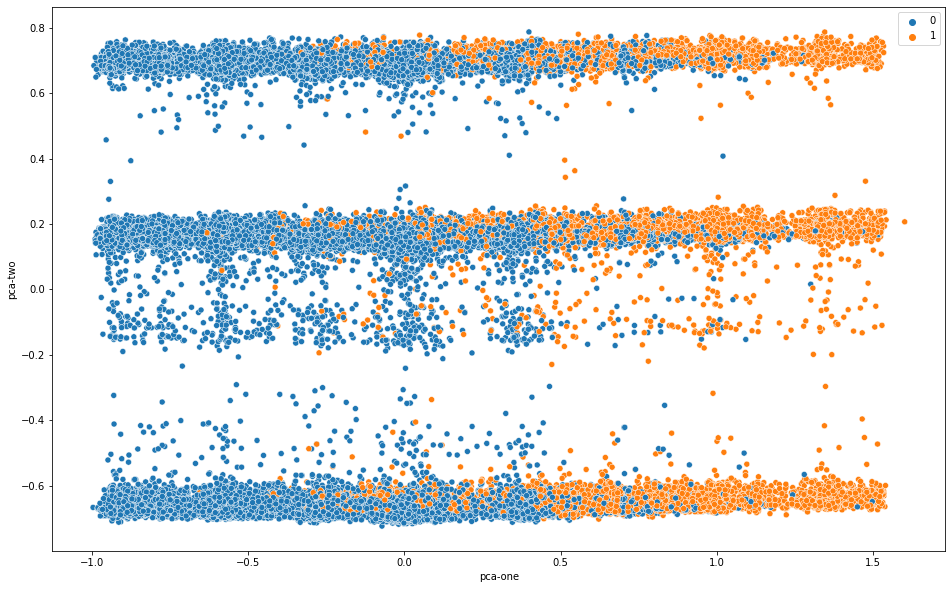

In [35]:
# linked = linkage(curr_df, 'single')
# plt.figure(figsize=(10, 7))
# dendrogram(linked,
#             orientation='top',
# #             labels=labelList,
#             distance_sort='descending',
#             show_leaf_counts=True)
# plt.show()


cluster = AgglomerativeClustering(n_clusters=NUMBER_OF_CLUSTERS, affinity='euclidean', linkage='ward')
cluster.fit_predict(curr_df)
# print(curr_df[:,0],curr_df[:,1])
# plt.scatter(curr_df["Q8N4B1"],curr_df["Q9UQQ2"], c=cluster.labels_, cmap='rainbow')
pca = PCA(n_components=2)
pca_result = pca.fit_transform(curr_df[list(curr_df.columns)[:-1]].values)
curr_df['pca-one'] = pca_result[:,0]
curr_df['pca-two'] = pca_result[:,1] 
curr_df["labels"] = cluster.labels_
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue=cluster.labels_,
#     palette=sns.color_palette("hls", 10),
    data=curr_df,
    legend="full",
#     alpha=0.3
)
plt.show()

In [36]:
curr_df["sex"] = ukbdataset_work["sex"]
curr_df["y"] = ukbdataset_work["group"]
curr_df["lable"] =  cluster.labels_
ukbdataset_work["group_clust"] = curr_df["lable"] 
res_dict = dict(curr_df.query('lable==1').mean() - curr_df.query('lable==0').mean())
del res_dict['y']
del res_dict['pca-two']
del res_dict['pca-one']
del res_dict['sex']
del res_dict["lable"]
del res_dict["labels"]

print(sorted(list(res_dict.items()),key=lambda x:np.abs(x[1])))


[('Q86US8', 5.3397606445293455e-05), ('P33241', 0.0001442914747237234), ('Q7Z2Z1', 0.00015807325094308045), ('Q0P670', 0.00021840380713811225), ('P09681', -0.00023884558395559363), ('Lymphocyte counts', -0.00024816318944216945), ('Q9UH65', -0.0002574089141685887), ('P0C7L1', -0.0002702316852000175), ('Q14183', 0.00030024533474692916), ('Q9Y6M7', 0.00033390862020310497), ('Q01970', -0.0003344436606432799), ('P53985', 0.00035339338696471767), ('White blood cell count', -0.00037522967525521755), ('Q96FS4', -0.00037842092542461625), ('P29474', -0.0005023880495270694), ('P08235', 0.0005112529905262342), ('Q86X59', 0.0005295646648066921), ('BMI', -0.0005604321968553094), ('Q14642', -0.0005650185308322397), ('O14905', 0.0007267101102682028), ('Q8IYN0', -0.0007745776290485895), ('P59942', 0.000816420442303456), ('Q16891', 0.0009093110268171278), ('P46379', -0.0010679542318544621), ('Q9P212', -0.001150501346386057), ('Q9NR81', -0.0011832731601935098), ('P51788', -0.0011887235906700155), ('Heigh

In [37]:
fp = len(ukbdataset_work.query("(group_clust == 0) and (I10 == 0.0) "))
tp = len(ukbdataset_work.query("(group_clust == 0) and (I10 == 1.0) "))
tn = len(ukbdataset_work.query("(group_clust == 1) and (I10 == 0.0) "))
fn = len(ukbdataset_work.query("(group_clust == 1) and (I10 == 1.0) "))
count = len(ukbdataset_work)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = tp / (tp + 1/2 * (fp + fn))
print("FP", round(fp/count,4))
print("TP",round(tp/count,4))
print("TN",round( tn/count,4))
print("FN",round( fn/count,4))
print("precision",round( precision,4))
print("recall", round(recall,4))
print("f1 score", round(f1,4))

# print(len(ukbdataset_work.query("I10 != group_clust")))
    
# print(len(ukbdataset_work.query("I10 != group_clust")))
# print("#" * 10)
# print(len(ukbdataset_work.query("E78 == group")))
# print(len(ukbdataset_work.query("E78 != group")))

# print(len(ukbdataset_work.query("I10 != group")))

FP 0.1265
TP 0.6285
TN 0.0373
FN 0.1718
precision 0.8324
recall 0.7853
f1 score 0.8082


<AxesSubplot:>

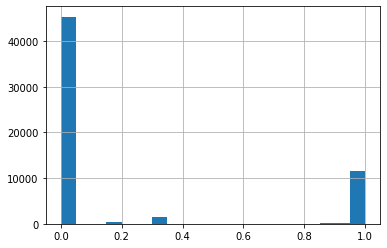

In [38]:
# print(len(ukbdataset_work))
df["Q10981"].hist(bins=20)

## Example

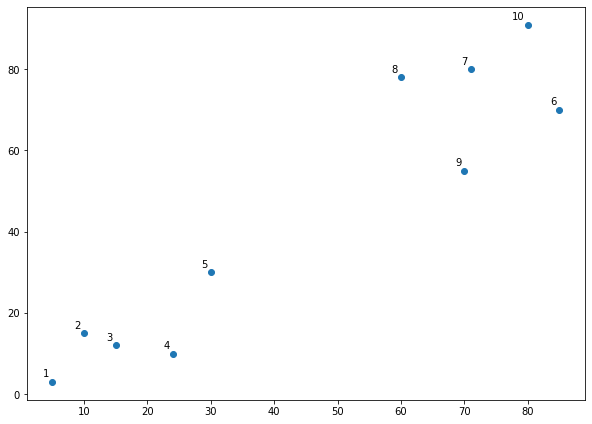

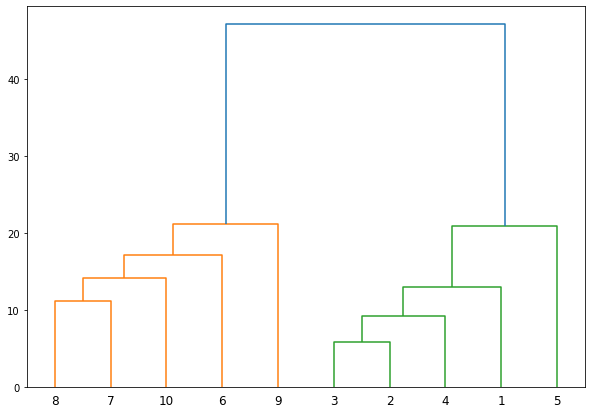

In [39]:
X = np.array([[5,3],
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],])
labels = range(1, 11)
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(X[:,0],X[:,1], label='True Position')

for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

linked = linkage(X, 'single')

labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()



[1 1 1 1 1 0 0 0 0 0]


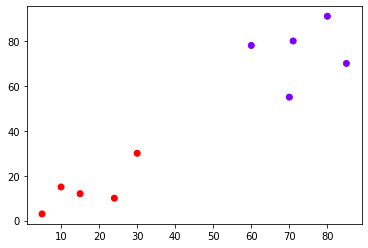

In [40]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)
print(cluster.labels_)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_, cmap='rainbow')


# risk score permutation tests

In [82]:
treatment = [ 28.44,  29.32,  31.22,  29.58,  30.34,  28.76,  29.21,  30.4 ,
              31.12,  31.78,  27.58,  31.57,  30.73,  30.43,  30.31,  30.32,
              29.18,  29.52,  29.22,  30.56]
control = [ 33.51,  30.63,  32.38,  32.52,  29.41,  30.93,  49.78,  28.96,
            35.77,  31.42,  30.76,  30.6 ,  23.64,  30.54,  47.78,  31.98,
            34.52,  32.42,  31.32,  40.72]
def perm_test_mlxtend(x_1,x_2,num_perms,statistic='approximate'):
    return permutation_test(x_1, x_2,
                           method=statistic,
                           num_rounds=num_perms)

p_value = permutation_test(treatment, control,
                           method='approximate',
                           num_rounds=10000)
print(perm_test_mlxtend(treatment,control,10000))


0.0052994700529947


In [42]:
def permutation_test_median(x_1,x_2,num_perms):
    T = np.abs(np.median(x_1)-np.median(x_2))
    m_1 = len(x_1)
    m_2 = len(x_2)
    T_perm = np.zeros(num_perms)
    X = np.concatenate((x_1,x_2))
    for j in range(num_perms):
        idx = np.random.permutation(len(X))
        T_perm[j] = np.abs(np.median(X[idx[:m_1]])-np.median(X[idx[(m_2+1):]]))
    p_perm = len(np.where(T_perm>T)[0])/(num_perms*1.0)
    return p_perm
def permutation_test_mean(x_1,x_2,num_perms):
    T = np.abs(np.mean(x_1)-np.mean(x_2))
    m_1 = len(x_1)
    m_2 = len(x_2)
    T_perm = np.zeros(num_perms)
    X = np.concatenate((x_1,x_2))
    for j in range(num_perms):
        idx = np.random.permutation(len(X))
        T_perm[j] = np.abs(np.mean(X[idx[:m_1]])-np.mean(X[idx[(m_2+1):]]))
    p_perm = len(np.where(T_perm>T)[0])/(num_perms*1.0)
    return p_perm

In [43]:
"""
A simple implementation of a permutation test among two
independent samples.
"""

import numpy as np
from sklearn.utils.validation import check_random_state
from more_itertools import distinct_permutations
from scipy.stats import percentileofscore
from math import factorial


def permtest(
        x, y, statistic="mean", max_samples=100000,
        random_state=None):
    """
    Conducts a permutation test between two independent
    samples.
    Parameters
    ----------
    x : ndarray
        First set of datapoints.
    y : ndarray
        Second set of datapoints.
    statistic : str or callable, optional
        Function that takes in samples x and y and reports
        statistic of interest. By default, "mean" reports
        the difference of sample means. List of default
        options are ("mean", "median").
    max_samples : int, optional.
        Maximum number of label permutations to try.
    random_state : np.random.RandomState, int, or None.
        If specified, used to seed the random number
        generator to shuffle the ordering of the
        datapoints.
    """

    # initialize random state and function of interest.
    rs = check_random_state(random_state)
    stat_func = _get_stat_func(statistic)

    # Concatenate samples in random order.
    xy = np.concatenate((x, y))
    rs.shuffle(xy)

    # Create data labels (True if sample is in "x" and False if sample
    # is in "y"), and randomly shuffle before generating permutations.
    labels = np.zeros_like(xy, dtype="bool")
    labels[:x.size] = True
    rs.shuffle(labels)

    # Number of distinct permutations.
    n_perms = factorial(xy.size) // factorial(x.size) // factorial(y.size)
#     print(n_perms)
#     n_perms = 100000

    # Allocate space for computed statistics.
    shuffled_stats = np.full(min(max_samples, n_perms), np.nan)

    # Print coverage.
#     print("Computing {0:} / {1:.2e} ({2:2.2f}%) of label permutations: ".format(
#         shuffled_stats.size, n_perms, 100 * shuffled_stats.size / n_perms
#     ))

    # Iterate over distinct permutations if we have sufficient coverage.
    # Otherwise, yield random permutations
    if (max_samples / n_perms) > 0.5:
#         print("Iterating over distinct permutations...")
        itr = distinct_permutations(labels)
    else:
#         print("Sampling random permutations...")
        itr = _randperms(rs, labels)

    # Iterate over distinct permutations.
    for i, perm in enumerate(itr):

        # End early.
        if i >= shuffled_stats.size:
            break

        # Create shuffled stand-ins for x and y.
        x_ = xy[np.asarray(perm)]
        y_ = xy[~np.asarray(perm)]

        # Compute statistic.
        shuffled_stats[i] = stat_func(x_, y_)

    # Compute a two-sided p-value. We take the smallest
    # percentile and then multiply by two.
    pval = 2 * 0.01 * min(
        percentileofscore(shuffled_stats, stat_func(x, y)),
        percentileofscore(shuffled_stats, stat_func(y, x))
    )

    return pval


def _get_stat_func(name_or_func):
    """
    Instantiates functions that compute default statistics of
    interest.
    """

    # If specified function is callable
    if not isinstance(name_or_func, str):
        if callable(name_or_func):
            return name_or_func
        else:
            raise ValueError(
                "`statistic` should be a string like ('mean', 'median')"
                " or a function that takes in samples x, y and returns"
                " the statistic of interest."
            )

    # Default functions.
    if name_or_func == "mean":
        return lambda x, y: np.mean(x) - np.mean(y)
    elif name_or_func == "median":
        return lambda x, y: np.median(x) - np.median(y)
    else:
        raise ValueError(
            "Did not recognize statistic."
        )


def _randperms(rs, labels):
    perm = labels.copy()
    while True:
        rs.shuffle(perm)
        yield perm


if __name__ == "__main__":

    np.random.seed(123)
    x = np.random.randn(100)
    y = .5 + np.random.randn(100)
    print(
        f"p = {permtest(x,y, random_state=None,max_samples=10)}"
    )


p = 0.0


In [120]:
def fill_perm_list(male_eid,female_eid,values_df,used_genes_set,test,*params):
    lst = []
    for gene in used_genes_set:
        values_df = values_df.dropna()
        male_values = np.array(values_df[values_df.index.isin(male_eid)][gene])
        female_values = np.array(values_df[values_df.index.isin(female_eid)][gene])
#         if list(male_values)!=list(female_values):
#             a = list(male_values)
#             b = list(female_values)
#             for i in range(len(male_values)):
#                 if male_values[i] != female_values[i]:
#                     print(i,male_values[i],female_values[i])

#         print(male_values == female_values)
        lst.append((gene,test(male_values,female_values,*params)))
#         print(lst[-1])
    return lst
#     print(len(male_values),len(female_values))
    
#     print(male_values)
    

In [45]:
# used_ids = list(ukbb_dataset.query("(I10 == 1.0 )")["eid"])
used_ids = list(ukbb_dataset.query("(E03 == 1.0 )")["eid"])
df ,df_m, df_f = E03_df,E03_M_df,E03_F_df
# used_ids = list(ukbb_dataset.query("(I10 == 1.0 or E78 == 1.0 ) and E78 != I10")["eid"])


genes_list = list(df.query("fdr_significance")["uniprot_id"])
length = min(len(genes_list),MAX_NUMBER_OF_GENES)
used_genes = (list(df.query("fdr_significance")["uniprot_id"]))
used_genes.extend(list(df_m.query("fdr_significance")["uniprot_id"]))
used_genes.extend(df_f.query("fdr_significance")["uniprot_id"])
used_genes_set = set(used_genes)
values_df = create_effect_score_df(EFFECT_SCORE_PATH,used_genes,used_ids,GENE_DICT)

17900


/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
# values_df
list(ukbb_dataset["sex"] == 1).count(False)
female_eid = list(ukbb_dataset[ukbb_dataset["sex"] == 0]["eid"])
male_eid  = list(ukbb_dataset[ukbb_dataset["sex"] == 1]["eid"])
# male_eid


In [47]:
values_df.index.isin([3769417])

array([False, False, False, ..., False, False, False])

In [49]:
# female_values.shape

In [122]:
ranges = [100,500,1000,5000,10000,15000,30000]
# ranges = [1000,5000]
mean_reg = []
med_reg = []
mean_other = []
med_other = []
mlxtend_approx = []
# permtest
for r in ranges:
    print(r)
    mlxtend_approx.append(fill_perm_list(male_eid,female_eid,values_df,used_genes_set,perm_test_mlxtend,r))
    
    mean_reg.append(fill_perm_list(male_eid,female_eid,values_df,used_genes_set,permutation_test_mean,r))
    med_reg.append(fill_perm_list(male_eid,female_eid,values_df,used_genes_set,permutation_test_median,r))
    mean_other.append(fill_perm_list(male_eid,female_eid,values_df,used_genes_set,permtest,"mean",r))    
    med_other.append(fill_perm_list(male_eid,female_eid,values_df,used_genes_set,permtest,"median",r))        

100
500
1000
5000
10000
15000
30000


In [132]:
sorted(mlxtend_approx[-1],key=lambda x:x[1])

[('P51617', 3.333222225925803e-05),
 ('Q9BXC1', 3.333222225925803e-05),
 ('Q04941', 0.00019999333355554815),
 ('Q8N1G4', 0.010099663344555181),
 ('P06729', 0.012866237792073597),
 ('P42081', 0.030965634478850704),
 ('O15054', 0.032498916702776576),
 ('Q9BU70', 0.03626545781807273),
 ('P20036', 0.05899803339888671),
 ('P51858', 0.0643978534048865),
 ('A6NKF2', 0.06993100229992334),
 ('P17693', 0.07656411452951568),
 ('O00453', 0.08093063564547849),
 ('P04440', 0.08619712676244125),
 ('P22105', 0.09216359454684844),
 ('Q8NHH9', 0.1117296090130329),
 ('P16410', 0.13096230125662478),
 ('Q6U7Q0', 0.1330288990366988),
 ('Q8TCS8', 0.14519516016132797),
 ('Q5SSG8', 0.14576180793973534),
 ('P58005', 0.15419486017132764),
 ('P78330', 0.15919469351021634),
 ('P01374', 0.16589447018432718),
 ('P05106', 0.17259424685843805),
 ('Q9H816', 0.182793906869771),
 ('Q7KYR7', 0.2101263291223626),
 ('Q16549', 0.23929202359921337),
 ('P01906', 0.26892436918769375),
 ('Q99466', 0.270124329189027),
 ('O95866',

In [ ]:
# ranges = [100,500,1000,5000,10000,15000,30000]

In [ ]:
# a,b,c,d = mean_reg,med_reg,mean_other,med_other

In [125]:
mean_reg_combined = []
med_reg_combined = []
mean_other_combined = []
med_other_combined = []
mlxtend_approx_combined = []
for i, r in enumerate(ranges):
    mean_reg_combined.append(np.array(sorted(mean_reg[i]))[:,1])
    med_reg_combined.append(np.array(sorted(med_reg[i]))[:,1])
    mean_other_combined.append(np.array(sorted(mean_other[i]))[:,1])
    med_other_combined.append(np.array(sorted(med_other[i]))[:,1])
    mlxtend_approx_combined.append(np.array(sorted(mlxtend_approx[i]))[:,1])
    

In [126]:
mean_reg_combined = -np.log10(np.array(mean_reg_combined).astype(np.float64) + 1e-10)
med_reg_combined = -np.log10(np.array(med_reg_combined).astype(np.float64)+ 1e-10)
mean_other_combined = -np.log10(np.array(mean_other_combined).astype(np.float64)+ 1e-10)
med_other_combined = -np.log10(np.array(med_other_combined).astype(np.float64)+ 1e-10)
mlxtend_approx_combined = -np.log10(np.array(mlxtend_approx_combined).astype(np.float64)+ 1e-15)


In [87]:
mlxtend_approx_combined

array([[4.24537777e-01, 3.32223516e-01, 1.05007886e+00, 9.25140128e-01,
        1.52720012e+00, 3.05351369e-01, 4.85807434e-01, 1.71812461e-01,
        5.41923376e-01, 4.24537777e-01, 3.32223516e-01, 9.25140128e-01,
        4.32137378e-03, 1.98141400e-01, 4.99171395e-01, 9.58363549e-02,
        1.00432137e+00, 9.25140128e-01, 1.40226138e+00, 1.30952981e-02,
        8.58193338e-01, 1.00432137e+00, 1.00432137e+00, 1.05007886e+00,
        1.53063025e-01, 2.11929684e-01, 2.18991539e-01, 1.52720012e+00,
        3.23080136e-01, 2.00432137e+00, 1.15922333e+00, 7.03291378e-01,
        1.05007886e+00, 1.17830649e-01, 2.00432137e+00, 2.65977685e-02,
        1.06694282e-01, 1.91408017e-01, 4.99171395e-01, 2.20501407e-02,
        6.82102079e-01, 4.52799815e-02, 5.49313671e-02, 4.02261382e-01,
        9.62928689e-01, 4.99171395e-01, 4.60253329e-01, 7.73872452e-01,
        3.14125294e-01, 4.13256767e-01, 5.89348026e-01, 4.48018873e-01,
        1.70329138e+00, 8.68617919e-03, 1.17830649e-01, 2.719276

/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
/cs/usr/roeizucker/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


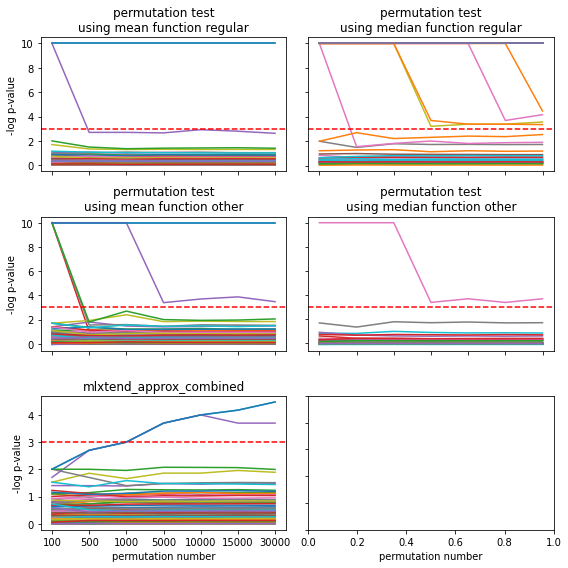

In [131]:
# plt.plot(mean_reg_combined)
# plt.title("permutation test - using mean function regula")
# plt.show()
fig, axs = plt.subplots(3, 2)
fig.set_figheight(8)
fig.set_figwidth(8)

axs[0, 0].set_title('permutation test\nusing mean function regular')
axs[0, 0].plot(mean_reg_combined)
axs[0, 0].axhline(y = 3, color = 'r', linestyle='dashed')

axs[0, 1].set_title('permutation test\nusing median function regular')
axs[0, 1].plot(med_reg_combined)
axs[0, 1].axhline(y = 3, color = 'r', linestyle='dashed')

axs[1, 0].set_title('permutation test\nusing mean function other')
axs[1, 0].plot(mean_other_combined)
axs[1, 0].set_xticklabels([100] + ranges)
axs[1, 0].axhline(y = 3, color = 'r', linestyle='dashed')

axs[1, 1].set_title('permutation test\nusing median function other')
axs[1, 1].plot(med_other_combined)
axs[1, 1].set_xticklabels([100] + ranges)
axs[1, 1].axhline(y = 3, color = 'r', linestyle='dashed')

axs[2, 0].set_title('mlxtend_approx_combined')
axs[2, 0].plot(mlxtend_approx_combined)
axs[2, 0].set_xticklabels([100] + ranges)
axs[2, 0].axhline(y = 3, color = 'r', linestyle='dashed')

# axs[0, 1].set_title('Axis [0, 1]')

# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='permutation number', ylabel='-log p-value')

for ax in axs.flat:
    ax.label_outer()
    
fig.tight_layout()
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)


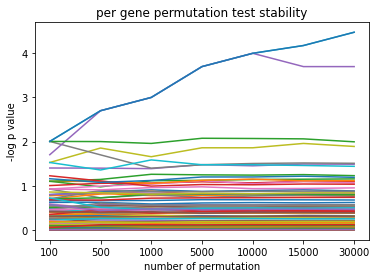

In [151]:
plt.title("per gene permutation test stability")
plt.plot(mlxtend_approx_combined)
plt.ylabel("-log p value")
plt.xlabel("number of permutation")
plt.xticks(list(range(len(ranges))),ranges)
plt.show()

array([[ 4.36119650e-01,  3.41563542e-01,  1.10123139e+00,
         1.00432137e+00,  1.40226138e+00,  2.48446518e-01,
         5.89348026e-01,  1.46988877e-01,  5.41923376e-01,
         5.72957610e-01,  3.23080136e-01,  7.73872452e-01,
        -4.82163733e-16,  1.29260110e-01,  4.85807434e-01,
         1.35089654e-01,  9.25140128e-01,  9.25140128e-01,
         1.52720012e+00, -4.82163733e-16,  8.00201391e-01,
         1.10123139e+00,  1.10123139e+00,  1.22617012e+00,
         2.71927614e-01,  2.48446518e-01,  1.84777438e-01,
         2.00432137e+00,  3.05351369e-01,  2.00432137e+00,
         1.15922333e+00,  7.03291378e-01,  7.03291378e-01,
         7.49024481e-02,  1.70329138e+00,  4.05335464e-02,
         1.40998514e-01,  2.63958684e-01,  4.02261382e-01,
         4.32137378e-03,  6.24110132e-01,  3.11935202e-02,
         6.98229225e-02,  4.13256767e-01,  8.00201391e-01,
         4.85807434e-01,  4.36119650e-01,  7.03291378e-01,
         3.05351369e-01,  4.99171395e-01,  6.61898693e-0

In [80]:
mlxtend_approx[-3]

[('Q96IY1', 1.0),
 ('Q7KYR7', 1.0),
 ('Q5SSQ6', 1.0),
 ('Q14653', 1.0),
 ('O15054', 1.0),
 ('Q9UQQ2', 1.0),
 ('P22105', 1.0),
 ('Q29980', 1.0),
 ('P34931', 1.0),
 ('P42081', 1.0),
 ('Q96G28', 1.0),
 ('P17693', 1.0),
 ('Q5SSG8', 1.0),
 ('Q8N4B1', 1.0),
 ('P01911', 1.0),
 ('A6NC98', 1.0),
 ('Q9BU70', 1.0),
 ('P01906', 1.0),
 ('P26640', 1.0),
 ('O15213', 1.0),
 ('Q6U7Q0', 1.0),
 ('Q13769', 1.0),
 ('P58005', 1.0),
 ('Q30154', 1.0),
 ('Q8NCL8', 1.0),
 ('Q92759', 1.0),
 ('Q9H816', 1.0),
 ('P01374', 1.0),
 ('P51617', 9.999000099990002e-05),
 ('Q6UW10', 1.0),
 ('Q9UIR0', 1.0),
 ('Q9Y6B7', 1.0),
 ('Q04941', 9.999000099990002e-05),
 ('P06729', 1.0),
 ('O95866', 1.0),
 ('Q8TBB0', 1.0),
 ('Q9UGF7', 1.0),
 ('P05106', 1.0),
 ('Q8TCS8', 1.0),
 ('Q8NGR1', 1.0),
 ('Q8TD31', 1.0),
 ('P04440', 1.0),
 ('P01889', 1.0),
 ('Q9Y242', 1.0),
 ('O00453', 1.0),
 ('Q9UIG4', 1.0),
 ('P78330', 1.0),
 ('P20036', 1.0),
 ('Q9UHP7', 1.0),
 ('O77932', 1.0),
 ('P49238', 1.0),
 ('Q6UXA7', 1.0),
 ('Q99880', 1.0),
 ('Q9NP31'

In [ ]:
count = 0
for pair in mean_reg[-1]:
    if pair[1] < 0.05:
        count+=1
        print(pair)
        print("reg", list(I10_df[I10_df["uniprot_id"] == pair[0]]["fdr_qval"]))
        print("male", list(I10_M_df[I10_M_df["uniprot_id"] == pair[0]]["fdr_qval"]))
        print("female", list(I10_F_df[I10_F_df["uniprot_id"] == pair[0]]["fdr_qval"]))
        print("#" * 40)
    
print(count)

In [ ]:
print(ranges)

In [ ]:
# lst = []
print(fill_perm_list(male_eid,female_eid,values_df,male_values,female_values,permtest,"mean",30))

In [ ]:
count = 0
for i in perm_pvalues_list_1000:
    if i[1] > 0.05:
        count +=1
print(count)

count = 0
for pair in perm_pvalues_list_1000:
    if pair[0] in female_sig_genes:
        if pair[1] < 0.05:
            count+=1
print(count)


In [ ]:
both_sig_genes = set(I10_df[I10_df.fdr_significance]["uniprot_id"])
female_sig_genes = set(I10_F_df[I10_F_df.fdr_significance]["uniprot_id"])
male_sig_genes = set(I10_F_df[I10_M_df.fdr_significance]["uniprot_id"])
only_female_sig_genes = female_sig_genes.difference(both_sig_genes)

In [ ]:

for pair in perm_pvalues_list_1000:
    if pair[0] in female_sig_genes:
        print(pair)
print("*"*30)
for pair in perm_pvalues_list_1000:
    if pair[0] in male_sig_genes:
        print(pair)
print("*"*30)
for pair in perm_pvalues_list_1000:
    if pair[0] in only_female_sig_genes:
        print(pair)


In [ ]:
# shuffled_stats.size